# 第一周周计划
韩昊阳

第一周的工作任务是：

    1. 配置电脑系统环境；
    2. 熟悉各个数据库中数据大小，类型，实际意义，调用方法；
    3. Linux远端环境配置；
    4. 对于一个已知结论(监督学习)的选股策略，搭建一个小的自变量、因变量已知的监督学习模型（多个模型进行筛选），并进行accuracy(cross validation/train_test split)/overfitting(bias/variance)等模型检验；
    5. 根据步骤4所得到的结果，给出模型选择结论；
    6. 后续工作。


## a. 电脑系统配置

安装如下环境和语言：

1. Anaconda Navigator(python 3.6);      https://www.anaconda.com
2. Numpy, pandas, sklearn, matplotlib, seaborn;    pip/conda install xxx
3. Tensorflow, Pytorch, word2vec, autograd, cupy;    pip/conda install xxx
4. chrome;    https://chrome.google.com
5. wolf(bash simulator for windows);
6. oracle/wind;
7. VPN.
8. Cuda.


注意：经过实测，需要下载anaconda-navigator的4.2.0版本（for python 3.5）（因为最新版本无法安装到本版本的电脑中），然后使用：

1. conda update anaconda-navigator
2. anaconda-navigator --reset
3. conda update -f anaconda-client
4. conda update jupyter_core jupyter client


的命令升级并支持anaconda和jupyter的使用

In [ ]:
!pip install numpy pandas sklearn matplotlib seaborn

In [ ]:
!python -m pip install --upgrade pip

In [ ]:
!pip3 install --upgrade tensorflow
!pip3 install --upgrade tensorflow-gpu

In [ ]:
!pip3 install --upgrade tensorflow

here we installed cuda version 9.2.


I followed this instruction: 
https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64&target_version=10&target_type=exenetwork

## b. 数据库熟悉

1. 熟悉数据平台操作，导入方法；
2. 了解主流数据因子中各个变量的实际意义，各因子大小(300MB)，本周实验中的各个变量具体意义和使用方法。

## c. Linux环境配置
和a.步骤相似，在linux环境下进行类似的步骤设计。

## d. 模型选择

#### 1.数据导入

In [1]:
# 1. Import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import time
import os


# Define Hyperparameters
T = 30

首先看一下单因子的数据形状：

In [ ]:
# 40000个时间点（每个时间点是1分钟）
# 1829支股票（只有1082支是有数据的）

In [2]:
x = np.memmap('/opt/hhyang/Data/factors/TSX[100001_1]',dtype = np.float32, shape = (40000,1829))# ,shape = (204800, 1749))
price = np.memmap('/opt/hhyang/Data/quotes/stk_clsadj',dtype = np.float32, shape = (40000,1829))# ,shape = (204800, 1749)) Here we have a shape error becasue memmap

In [104]:
# test of reshape
x = np.asarray(x)
x = x.reshape(-1)
x.shape

(73160000,)

In [3]:
x0 = x[:,1081]
x1 = x[0,:]

In [4]:
x1

memmap([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [5]:
x0[:50]

memmap([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00684157, 0.0084273 , 0.0084273 , 0.0088849 ,
        0.01046892, 0.01369885, 0.01142872, 0.01325133, 0.01532341,
        0.01483199, 0.01731646, 0.01590588, 0.00909106, 0.01247884,
        0.01247884, 0.01293565, 0.01840759, 0.01863695, 0.01451939,
        0.01496623, 0.01040026, 0.01172508, 0.01753635, 0.01329297,
        0.01483187, 0.0170868 , 0.01533633, 0.01464475, 0.01464475],
       dtype=float32)

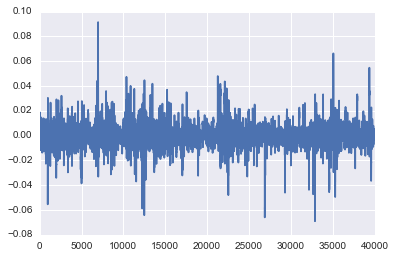

In [6]:
plt.plot(x0)
plt.show()

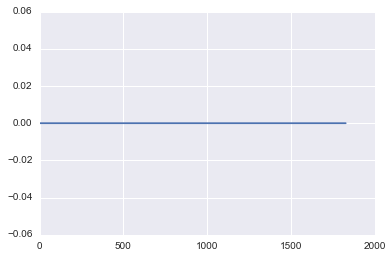

In [7]:
plt.plot(x1)
plt.show()

In [8]:
print(price.shape)
T = 30

(40000, 1829)


In [9]:
len(range(1081))

1081

In [10]:
y = np.zeros((price.shape[0]-T,price.shape[1]))

In [16]:
y = np.zeros((price.shape[0]-T,price.shape[1]))
'''
This is an iteration to create target y function;
Here we use Return rate minus Average Return Rate.

First we calculate the mean return rate for every single timeslot;
Then we calculate the return rate of each stock and return them back to y.

Here we used np.nanmean() function, in case some values would be nan.
'''
t0 = time.time()
for i in range(40000-T): 
    avg = []
    for j in range(1082):
        avg.append(np.log(price[i+T,j-1]/price[i,j-1]))
    average = np.nanmean(avg)
    if i <= 10:
        print(average)
    for j in range(1082):
        y[i,j-1] = np.log(price[i+T,j-1]/price[i,j-1])-average
t1 = time.time()

print("y function running time should be, ", t1-t0)

0.0013800772
0.0016703203
0.0011641694
0.00053213275
2.9085128e-05
0.00012998495
0.00043640524
0.0013618168
0.0022976901
0.0023563607
0.0025168792
y function run time should be,  277.69895124435425


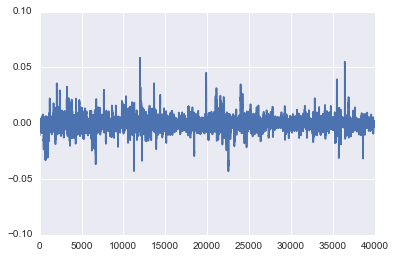

In [12]:
plt.plot(y[:,499])
plt.ylim((-0.1,0.1))
plt.show()

In [13]:
y.shape
# This shape should be equal to price.shape[0]-T, price.shape[1]

(39970, 1829)

多因子分析：

In [2]:
def import_dataset():
    '''
    read all 2-byte files and then concentrating them together. Follow this link:
    https://blog.csdn.net/brucewong0516/article/details/79062340
    '''
    x = []
    y = []
    # import x
    address = os.listdir(r'/opt/hhyang/Data/factors')
    for path in address:
        parent = r'/opt/hhyang/Data/factors'
        abs_path = os.path.join(parent, path)
        x_i = np.memmap(abs_path,dtype = np.float32, shape = (40000,1829))# ,shape = (204800, 1749))
        x_i = np.asarray(x_i)
        x_i = x_i[:,0:1082]
        x_ = x_i.reshape(-1,1)
        x.append(x_)
        # print(abs_path)
    # import y
    price = np.memmap('/opt/hhyang/Data/quotes/stk_clsadj',dtype = np.float32, shape = (40000,1829))# ,shape = (204800, 1749))
    
    y = np.zeros((price.shape[0]-T,price.shape[1]))
    '''
    This is an iteration to create target y function;
    Here we use Return rate minus Average Return Rate.

    First we calculate the mean return rate for every single timeslot;
    Then we calculate the return rate of each stock and return them back to y.

    Here we used np.nanmean() function, in case some values would be nan.
    '''
    t0 = time.time()
    for i in range(40000-T): 
        avg = []
        for j in range(1082):
            avg.append(np.log(price[i+T,j-1]/price[i,j-1]))
        average = np.nanmean(avg)
        if i == 0:
            print("printing sample return rate:\n")
        if i <= 10:
            print(average)
        for j in range(1082):
            y[i,j-1] = np.log(price[i+T,j-1]/price[i,j-1])-average
    t1 = time.time()
    y = y[:,0:1082]
    y_ = y.reshape(-1,1)
    

    print("y function running time should be, ", t1-t0)
    print("the shape of x is:", np.shape(x))
    print("the shape of y is:", y_.shape)
    return x, y

In [3]:
x_, y_ = import_dataset()


printing sample return rate:

0.0013800772
0.0016703203
0.0011641694
0.00053213275
2.9085128e-05
0.00012998495
0.00043640524
0.0013618168
0.0022976901
0.0023563607
0.0025168792
y function running time should be,  605.5384454727173
the shape of x is: (21, 43280000, 1)
the shape of y is: (43247540, 1)


#### 2.数据特征判断


基础的数据特征判断，例如mean, var, quantile, outlier, distribution等。

In [55]:
# 2. data characteristics recognition

'''
mean
variance
quantile
outlier
distribution
normalization?
'''

'\nmean\nvariance\nquantile\noutlier\ndistribution\nnormalization?\n'

In [53]:
def describe(x):
    '''
    This is a description function to evaluate the characteristic of single stock.
    Here I used this link: https://jingyan.baidu.com/article/6f2f55a18033aeb5b83e6c41.html
    '''
    x_numpy = np.asarray(x)
    x_numpy = x_numpy[:,0:1082]
    x_max = np.amax(x_numpy, axis = 0)
    x_min = np.amin(x_numpy, axis = 0)
    x_nor = (x_numpy - x_numpy.mean())/x_numpy.std()
    x_max_nor = np.amax(x_nor, axis = 0)
    x_min_nor = np.amin(x_nor, axis = 0)
    
    print("the shape of this input array is:",x_numpy.shape)
    print("the mean of this input array is:",x_numpy.mean())
    print("the var of this input array is:",x_numpy.var())
    print("25th percentile value is:",np.percentile(x_numpy,25))
    print("75th percentile value is:",np.percentile(x_numpy,75))
    print("Plotting the maximum and minimum value line:\n")
    
    plt.plot(x_max, label = 'Maximum value for each stock')
    plt.plot(x_min, label = 'Minimum value for each stock')
    plt.xlabel('stocks')
    plt.ylabel('factor values')
    plt.legend()
    plt.show()
    
    print("Plotting the normalized dataset's character:\n")
    plt.plot(x_max_nor, label = 'Normalized maximum value for each stock')
    plt.plot(x_min_nor, label = 'Normalized minimum value for each stock')
    plt.xlabel('stocks')
    plt.ylabel('Normalized factor values')
    plt.legend()
    plt.show()

the shape of this input array is: (40000, 1082)
the mean of this input array is: -5.3020445e-05
the var of this input array is: 4.0476076e-05
25th percentile value is: -0.0024531150702387094
75th percentile value is: 0.0021015957463532686
Plotting the maximum and minimum value line:



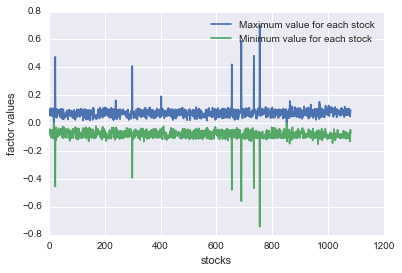

Plotting the normalized dataset's character:



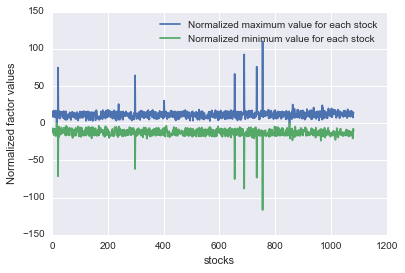

In [54]:
describe(x)

#### 3.特征工程
通过肉眼观测, Spearson Correlation, heatmap等形式筛选本模型所需要的自变量。

In [ ]:
# leave it null at this time, to make feature engineering in future.

#### 4.变量合并，训练/测试集拆分

In [4]:
def train_test_split(x, y):
    '''
    此时的情况是：T = 30，
                  40000 * 1082（21个features）的input x，被拉长为4.328e7 * 21 的数列。
                  39970 * 1082（1个output return）的output，被拉长为4.3248e7 * 21的数列。
    举简单的例子：用T = 3的情况，此时前面三个没有数字
 X：| | | | | | | |
    | | | | | | | |
    | | | | | | | |
    | | | | | | | |
    | | | | | | | |
    | | | | | | | |
 P：| | | | | | | |
 Y:       | | | | | | | |
    但是后面三个predicted y其实也没有（因为没有相对应的price做预测）
    既然是相对收益率，那我认为应当截去X的头部30（行）（因其无法产生任何有效的收益率数值）
    train_test分裂暂时使用35000-30:5000
        x_numpy = x_numpy[,:0:1:,]
    '''
    x = np.asarray(x)
    y = np.asarray(y)
    y = y.reshape(-1,1)
    # Cut first 30 rows of x
    # 30 * 1082 = 32460
    x = x[:,32460:,:]
    '''

    # transfer nan to 0
    x = np.nan_to_num(x)
    y = np.nan_to_num(y)
    '''
    print(np.shape(x))
    print(y.shape)
    
    # cutting first 
    train_X = np.squeeze(x[:,:37837540,:]).T    # 3-D to 2-D
    train_y = y[:37837540,:]
    test_X = np.squeeze(x[:,37837540:,:]).T
    test_y = y[37837540:,:]
    
    train_X= np.nan_to_num(train_X)
    train_y= np.nan_to_num(train_y)
    test_X= np.nan_to_num(test_X)
    test_y= np.nan_to_num(test_y)
    
    print("The shape of training set's X is,",train_X.shape)
    print("The shape of training set's y is,",train_y.shape)
    print("The shape of testing set's X is,",test_X.shape)
    print("The shape of testing set's y is,",test_y.shape)

    
    return train_X, train_y, test_X, test_y

In [5]:
train_X, train_y, test_X, test_y = train_test_split(x_, y_)

(21, 43247540, 1)
(43247540, 1)
The shape of training set's X is, (37837540, 21)
The shape of training set's y is, (37837540, 1)
The shape of testing set's X is, (5410000, 21)
The shape of testing set's y is, (5410000, 1)


#### 5. 模型拟合


这里我们首先先用sklearn进行一系列的最简单的模型判断，以确保我们的数据和模型是可以使用的。在这个条件下，我们暂时用RMSE作为评判标准，因为数据大小变化不明显，用MSE作为评判标准会出现数值过小而无法评价的问题。

使用的模型为：
1. Linear
2. Ridge
3. Kernel Ridge
4. Lasso
5. Bayesian
6. Polynominal
7. Decision Tree
8. Random Forest
9. Bagging Regression
10. Gradient Boosting Decision Tree
11. AdaBoost
12. SVM regression

In [53]:
# Preparing for several judgement parameter



# Accuracy
from sklearn.metrics import accuracy_score as acc_s
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import pearsonr

'''
Since this is a regression problem instead of classification, 
we shouldn't use accuracy_score(compared one element from each other in this case .)
Use MSE and RMSE criteria instead.

'''

def rmse(y_test, y_pred):
    return np.sqrt(mse(y_test, y_pred))

def IC(x1, x2):
    pearson = []
    x1 = np.squeeze(x1)
    x2 = np.squeeze(x2)
    for i in range(int(np.shape(x1)[0]/1082)):
        x1_ = x1[i*1082:i*1082+1082,]
        x2_ = x2[i*1082:i*1082+1082,]
        pearson_ = pearsonr(x1_, x2_)[0]
        pearson.append(pearson_)
    pearson = np.asarray(pearson)
    pearson = np.squeeze(pearson)
    '''
    print(np.isnan(pearson).sum())
    print(pearson.shape)
    print(pearson.mean())
    print(pearson.std())
    '''
    temp = pearson.mean()/pearson.std()
    return temp

def nan_transfor(x):
    where_are_nan = np.isnan(x)
    where_are_inf = np.isinf(x)
    x[where_are_nan] = 0
    x[where_are_nan] = 0
    return x

def predictor(func):
    y_hat = func.predict(pred_x)
    y_hat = y_hat.reshape(40000,-1)
    return y_hat

In [7]:
'''
Clear content of all memories
'''
Method = []
MSE = []
RMSE = []
Time = []
y_hat = []
ic = []

##### a. Linear

In [8]:
# Here we will import several functions in sklearn for model simulation.
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
t0 = time.time()
linear.fit(train_X, train_y)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = linear.predict(test_X)
accuracy1 = mse(pred_y, test_y)
accuracy2 = rmse(pred_y, test_y)
accuracy3 = IC(pred_y, test_y)
print("The mse of linear regression is:", accuracy1)
print("The rmse of linear regression is:", accuracy2)
print("The IC criteria is:", accuracy3)

Method.append('Linear')
MSE.append(accuracy1)
RMSE.append(accuracy2)
ic.append(accuracy3)
Time.append(t1-t0)
y_hat.append(pred_y)


total time used for model fitting is: 13.771728992462158
The mse of linear regression is: 4.439202839843727e-05
The rmse of linear regression is: 0.006662734303455097
The IC criteria is: 1.653328944093768


##### b. Ridge

In [9]:
# Here we will import several functions in sklearn for model simulation.
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 0.5)
t0 = time.time()
ridge.fit(train_X, train_y)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = ridge.predict(test_X)
accuracy1 = mse(pred_y, test_y)
accuracy2 = rmse(pred_y, test_y)
accuracy3 = IC(pred_y, test_y)

print("The mse of linear regression is:", accuracy1)
print("The rmse of linear regression is:", accuracy2)
print("The IC criteria is:", accuracy3)

Method.append('Ridge')
MSE.append(accuracy1)
RMSE.append(accuracy2)
ic.append(accuracy3)
Time.append(t1-t0)
y_hat.append(pred_y)

/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.034174e-27
  overwrite_a=True).T


total time used for model fitting is: 5.480012655258179
The mse of linear regression is: 1.130734646544653e-05
The rmse of linear regression is: 0.003362639806081902
The IC criteria is: 24.51892973515685


##### c. Kernel Ridge

In [11]:
train_y_ =  np.squeeze(train_y)
test_y_ =  np.squeeze(test_y)
train_y_.shape

(37837540,)

In [63]:
# Here we will import several functions in sklearn for model simulation.
from sklearn.kernel_ridge import KernelRidge
kridge = KernelRidge(kernel = 'linear', alpha = 0.1, gamma = 10)
t0 = time.time()
kridge.fit(train_X, train_y)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = kridge.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of linear regression is:", accuracy1)
print("The rmse of linear regression is:", accuracy2)

Method.append('Kernel Ridge')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

MemoryError: 

##### d. Lasso

In [23]:
# Here we will import several functions in sklearn for model simulation.
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.1)
t0 = time.time()
lasso.fit(train_X, train_y)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y_ = lasso.predict(test_X)
accuracy1 = mse(pred_y_, test_y)
accuracy2 = rmse(pred_y_, test_y)
print("The mse of linear regression is:", accuracy1)
print("The rmse of linear regression is:", accuracy2)

Method.append('Lasso')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y_)

accuracy3 = IC(pred_y_, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


total time used for model fitting is: 1234.7652115821838
The mse of linear regression is: 4.4044795717831626e-05
The rmse of linear regression is: 0.006636625326009569
The IC criteria is: 1.2480264986594305


##### e. Bayesian

In [12]:
# Here we will import several functions in sklearn for model simulation.
from sklearn.linear_model import BayesianRidge
bridge = BayesianRidge()
t0 = time.time()
bridge.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = bridge.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of linear regression is:", accuracy1)
print("The rmse of linear regression is:", accuracy2)

Method.append('Bayesian')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 67.39388370513916
The mse of linear regression is: 1.1307285071999888e-05
The rmse of linear regression is: 0.003362630677312019
The IC criteria is: 24.520109671042466


##### f. Polynominal

In [ ]:
'''
Polynominal 是一种延伸变量的预处理手段，不是回归时的模型。

# Here we will import several functions in sklearn for model simulation.
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
t0 = time.time()
poly.fit(train_X, train_y)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = poly.predict(test_X)
accuracy1 = mse(pred_y, test_y)
accuracy2 = rmse(pred_y, test_y)
print("The mse of linear regression is:", accuracy1)
print("The rmse of linear regression is:", accuracy2)

Method.append('Polynomial')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

'''


##### g. Decision Tree

调参方法主要看官方文档

In [13]:
from sklearn.tree import DecisionTreeRegressor
DTregression = DecisionTreeRegressor(splitter = 'random',
                                    max_features = 'log2',
                                    max_depth = 10,
                                    min_samples_split = 10,
                                    min_samples_leaf = 10,
                                    )

t0 = time.time()
DTregression.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = DTregression.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of Decision Tree regression is:", accuracy1)
print("The rmse of Decision Tree regression is:", accuracy2)

Method.append('Decision Tree')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 57.12978005409241
The mse of Decision Tree regression is: 2.4114081521262996e-05
The rmse of Decision Tree regression is: 0.004910609078440575
The IC criteria is: 16.37912165648452


##### h. RF

In [14]:
from sklearn.ensemble import RandomForestRegressor
RFregression = RandomForestRegressor(max_features = 'log2',
                                     max_depth = 10,
                                     min_samples_split = 10,
                                     min_samples_leaf = 10,
                                     n_jobs = 10
                                    )

t0 = time.time()
RFregression.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = RFregression.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of Random Forest regression is:", accuracy1)
print("The rmse of Random Forest regression is:", accuracy2)

Method.append('Random Forest')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 295.29906487464905
The mse of Random Forest regression is: 1.083403605033247e-05
The rmse of Random Forest regression is: 0.003291509691666192
The IC criteria is: 42.48074194335124


##### i.Bagging

In [ ]:
# 不知道为什么 Bagging跑的时间特别长？？跑了一晚上没出结果
from sklearn.ensemble import BaggingRegressor
bag = BaggingRegressor(n_jobs = 10)

t0 = time.time()
bag.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = bag.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of Random Forest regression is:", accuracy1)
print("The rmse of Random Forest regression is:", accuracy2)

Method.append('Bagging')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

##### j.GBDT

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
GBDT = GradientBoostingRegressor(n_estimators = 10,
                                subsample = 0.5,
                                min_samples_split = 10,
                                min_samples_leaf = 10,
                                max_features = 'log2',
                                alpha = 0.9)

t0 = time.time()
GBDT.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = GBDT.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of Random Forest regression is:", accuracy1)
print("The rmse of Random Forest regression is:", accuracy2)

Method.append('GBDT')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 735.9421718120575
The mse of Random Forest regression is: 2.3620359510898472e-05
The rmse of Random Forest regression is: 0.004860078138353176
The IC criteria is: 28.636866929468507


##### k.AdaBoost

In [69]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(n_estimators = 10)

t0 = time.time()
ada.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = ada.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of Random Forest regression is:", accuracy1)
print("The rmse of Random Forest regression is:", accuracy2)

Method.append('AdaBoost')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 5100.945332288742
The mse of Random Forest regression is: 4.257851327612542e-05
The rmse of Random Forest regression is: 0.006525221320087574
The IC criteria is: 5.721919114631133


##### i.Support Vector Machine

In [131]:
train_y_ =  np.squeeze(train_y)
test_y_ =  np.squeeze(test_y)
train_y_.shape

(37837540,)

In [132]:
from sklearn.svm import SVR
svmregression = SVR(C=1.0, epsilon=0.2)

t0 = time.time()
svmregression.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = svmregression.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of SVM regression is:", accuracy1)
print("The rmse of SVM regression is:", accuracy2)



Method.append('SVM')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 2033.369295835495
The mse of SVM regression is: 0.0007306737586663361
The rmse of SVM regression is: 0.027030977760087335
The IC criteria is: 0.15087742969332227


##### 6. 导出数据, 数据分析

In [133]:
Dict = {
    'mse':np.asarray(MSE),
    'rmse':np.asarray(RMSE),
    'time':np.asarray(Time),
    'IC':np.asarray(ic),
    # 'y_hat':y_hat
    # dataframe
}
result = pd.DataFrame(Dict, index = Method)


In [134]:
result

,mse,rmse,time,IC
Linear,0.000044,0.006663,13.771729,1.653329
Ridge,0.000011,0.003363,5.480013,24.518930
Bayesian,0.000011,0.003363,67.393884,24.520110
Decision Tree,0.000024,0.004911,57.129780,16.379122
Random Forest,0.000011,0.003292,295.299065,42.480742
GBDT,0.000024,0.004860,735.942172,28.636867
Lasso,0.000044,0.006637,1234.765212,1.248026
AdaBoost,0.000043,0.006525,5100.945332,5.721919
SVM,0.000731,0.027031,2033.369296,0.150877


In [72]:
result.to_csv('/opt/hhyang/result.csv')

<Figure size 432x288 with 0 Axes>

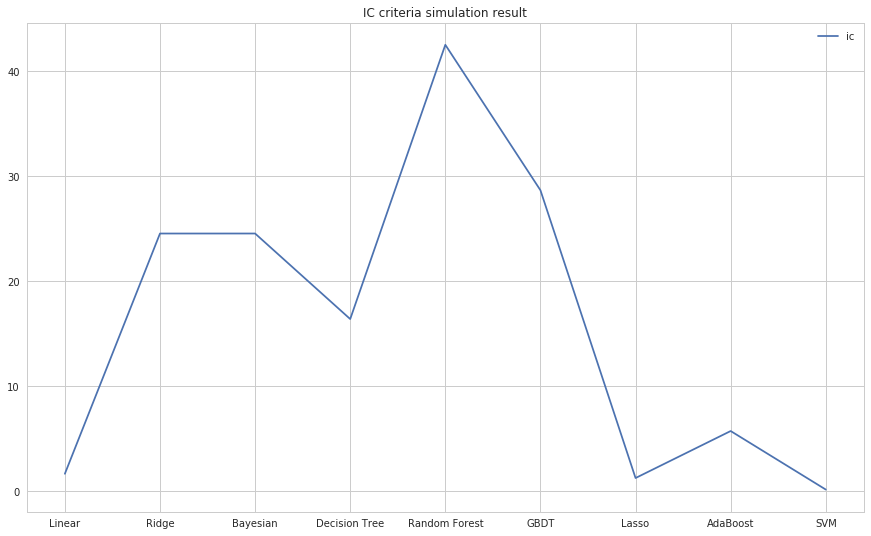

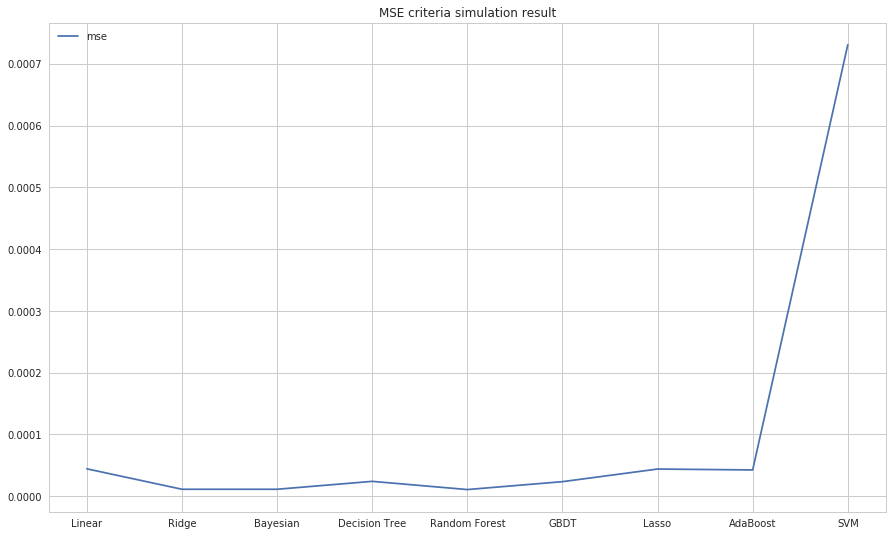

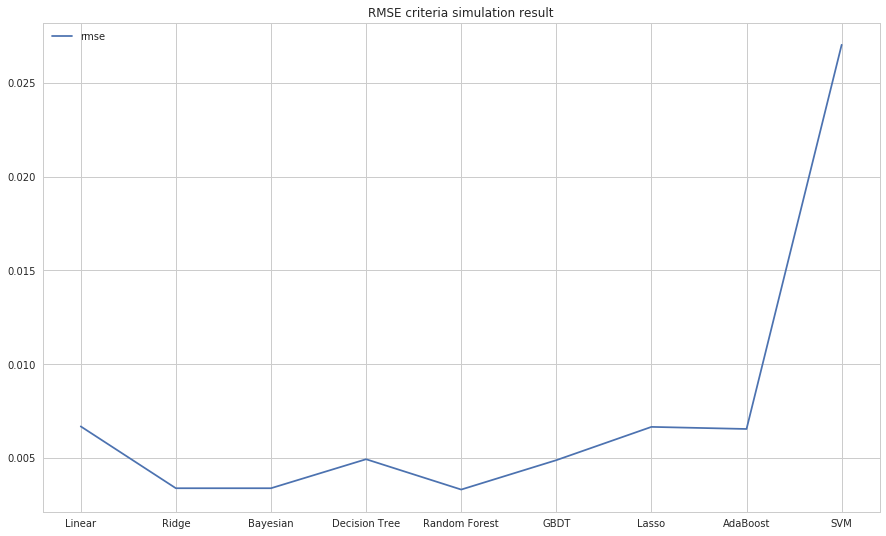

In [137]:

sns.despine()  
sns.set_style("whitegrid")  
plt.figure(figsize=(15,9))
plt.plot(result['IC'], label = 'ic')
plt.title("IC criteria simulation result")
plt.legend()
plt.show()

plt.figure(figsize=(15,9))
plt.plot(result['mse'], label = 'mse')
plt.title("MSE criteria simulation result")
plt.legend()
plt.show()

plt.figure(figsize=(15,9))
plt.plot(result['rmse'], label = 'rmse')
plt.title("RMSE criteria simulation result")
plt.legend()
plt.show()

In [59]:
# reshaping input x
pred_x = np.squeeze(x_).T
pred_x = nan_transfer(pred_x)
pred_x.shape

# outputs
y_hat_linear = predictor(linear)
y_hat_ridge = predictor(ridge)
y_hat_bridge = predictor(bridge)
y_hat_DTregression = predictor(DTregression)
y_hat_RFregression = predictor(RFregression)
y_hat_GBDT = predictor(GBDT)
y_hat_lasso = predictor(lasso)
y_hat_ada = predictor(ada)

In [65]:
np.savetxt('/opt/hhyang/linear.txt',y_hat_linear)
np.savetxt('/opt/hhyang/ridge.txt',y_hat_ridge)
np.savetxt('/opt/hhyang/bridge.txt',y_hat_bridge)
np.savetxt('/opt/hhyang/DecisionTree.txt',y_hat_DTregression)
np.savetxt('/opt/hhyang/RandomForest.txt',y_hat_RFregression)
np.savetxt('/opt/hhyang/GBDT.txt',y_hat_GBDT)
np.savetxt('/opt/hhyang/Lasso.txt',y_hat_lasso)
np.savetxt('/opt/hhyang/ada.txt',y_hat_ada)

In [103]:
# Stacking zeros for type
zeros = np.zeros((40000, 747))
y_hat_linear = np.c_[y_hat_linear, zeros]
y_hat_ridge = np.c_[y_hat_ridge, zeros]
y_hat_bridge = np.c_[y_hat_bridge, zeros]
y_hat_DTregression = np.c_[y_hat_DTregression, zeros]
y_hat_RFregression = np.c_[y_hat_RFregression, zeros]
y_hat_GBDT = np.c_[y_hat_GBDT, zeros]
y_hat_lasso = np.c_[y_hat_lasso, zeros]
y_hat_ada = np.c_[y_hat_ada, zeros]

In [114]:
# Stacking zeros for type
zero = np.zeros((320, 1829))
y_hat_linear = np.r_[y_hat_linear, zero]
y_hat_ridge = np.r_[y_hat_ridge, zero]
y_hat_bridge = np.r_[y_hat_bridge, zero]
y_hat_DTregression = np.r_[y_hat_DTregression, zero]
y_hat_RFregression = np.r_[y_hat_RFregression, zero]
y_hat_GBDT = np.r_[y_hat_GBDT, zero]
y_hat_lasso = np.r_[y_hat_lasso, zero]
y_hat_ada = np.r_[y_hat_ada, zero]

In [117]:
# Transfer float64 into float32
y_hat_linear = y_hat_linear.astype('float32')
y_hat_ridge = y_hat_ridge.astype('float32')
y_hat_bridge = y_hat_bridge.astype('float32')
y_hat_DTregression = y_hat_DTregression.astype('float32')
y_hat_RFregression = y_hat_RFregression.astype('float32')
y_hat_GBDT = y_hat_GBDT.astype('float32')
y_hat_lasso = y_hat_lasso.astype('float32')
y_hat_ada = y_hat_ada.astype('float32')

In [120]:
y_hat_linear.dtype

dtype('float32')

In [118]:
# Output into requried type.
# 288 k kb
y_hat_linear.tofile('/opt/hhyang/linear.bin')
y_hat_ridge.tofile('/opt/hhyang/ridge.bin')
y_hat_bridge.tofile('/opt/hhyang/bridge.bin')
y_hat_DTregression.tofile('/opt/hhyang/DTregression.bin')
y_hat_RFregression.tofile('/opt/hhyang/RFregression.bin')
y_hat_GBDT.tofile('/opt/hhyang/GBDT.bin')
y_hat_lasso.tofile('/opt/hhyang/lasso.bin')
y_hat_ada.tofile('/opt/hhyang/ada.bin')

##### Logistics 不用了

这里要用标准化的方法。
x_bar = (x - MIN)/(MAX-MIN)

回归问题不要用分类模型（虽然可以做）

In [ ]:
'''
Standardization process.
'''
y_max = np.nanmax(y_)
y_min = np.nanmin(y_)
def standardization(x):
    return (x-y_min)/(y_max - y_min)
train_y_logistic = standardization(train_y)
test_y_logistic = standardization(test_y)

In [23]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
t0 = time.time()
logistic.fit(train_X, train_y_logistic)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = logistic.predict(test_X)
accuracy1 = mse(pred_y, test_y_logistic)
accuracy2 = rmse(pred_y, test_y_logistic)
print("The mse of logistics regression is:", accuracy1)
print("The rmse of logistics regression is:", accuracy2)

/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: 'continuous'

## 6. 后续工作

后续工作会根据之前工作的进行，大致方向为：研究 in-sample/out of sample strategy 进行一些机器学习的研究：
    1. 训练出模型/accuracy/bais/variance 尝试各种各样的建模方式 最顺手而且性能更好；
    2. 做出模型后如何进行交易、什么条件下进行买卖、增强学习。


1. 因模型运作时间过长，我们需要继续探索Bagging/SVM/Kernal Ridge Regression的运作情况。

In [126]:
# Bagging Regression

In [127]:
# SVM Regression

In [128]:
# Kernal Ridge Regression

2. 使用如下优化方法对模型进行优化：

In [17]:
# Normalized Gradient Descent

In [18]:
# Stogastic Gradient Descent

In [19]:
# Batch Gradient Descent

In [20]:
# Monmentum Gradient Descent

3. 使用如下深度学习模型拟合数据：

In [121]:
# MLP

In [21]:
# Simple RNN

In [22]:
# GRU-RNN

In [129]:
# LSTM-RNN

In [130]:
# GAN-RNN

4. 使用如下降维方式增加效率

In [122]:
# PCA

In [123]:
# LDA

In [124]:
# LLE 

In [125]:
# Laplacian Eigenmaps